## Thư viện

In [ ]:
import glob2
from PIL import Image

import cv2
from skimage import feature

import numpy as np

import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Demo

In [ ]:
# gray_round = []
# H = feature.hog(gray_round, orientations=9, pixels_per_cell=(8, 8),
                # cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2",feature_vector=True)

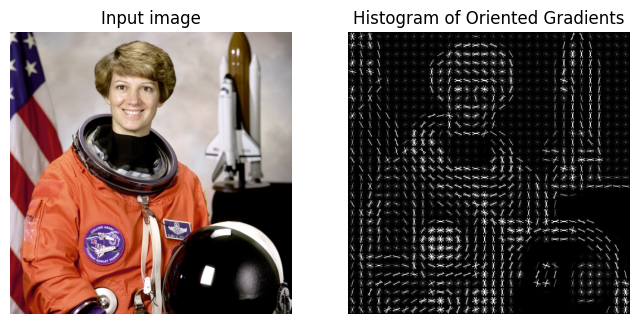

In [ ]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure


image = data.astronaut()

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

## Dữ liệu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip /content/drive/MyDrive/LTSSUD/Data/archive.zip;
print("Finished!")

Streaming output truncated to the last 5000 lines.
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   
  inflating: PetImages/Dog/5520.jpg  
  inflating: PetImages/Dog/5521.jpg  
  inflating: PetImages/Dog/5522.jpg  

In [ ]:
link_cat = r"PetImages/Cat/**"
link_dog = r"PetImages/Dog/**"

In [ ]:
images  = []
labels = []
list_cat = glob2.glob(link_cat)
print(len(list_cat))
for i in range(500):
    if('jpg' in list_cat[i]):
        img = Image.open(list_cat[i]).convert('RGB')
        img = img.resize((400,400), Image.LANCZOS)
        if len(np.array(img).shape)  == 3:
            images.append(np.array(img))
            labels.append(1)

12501


In [ ]:
list_dog = glob2.glob(link_dog)
print(len(list_dog))
for i in range(500):
    if('jpg' in list_dog[i]):
        img = Image.open(list_dog[i]).convert('RGB')
        img = img.resize((400,400), Image.LANCZOS)
        if len(np.array(img).shape)  == 3:
            images.append(np.array(img))
            labels.append(-1)

12501


## Ảnh gốc

In [ ]:
# chọn số lượng ảnh gốc tùy theo yêu cầu images_per_class
images_per_class = 500
raw_images = [image.flatten() for image in images[:images_per_class]]
raw_images.extend([image.flatten() for image in images[500:500+images_per_class]])
raw_images = np.array(raw_images)


small_labels = [label for label in labels[:images_per_class]]
small_labels.extend([label for label in labels[500:500+images_per_class]])
small_labels = np.array(small_labels)

In [ ]:
raw_images.shape

(1000, 480000)

In [ ]:
small_labels.shape

(1000,)

## Trích xuất đặc trưng với HOG

### Code HOG nhóm

In [ ]:
# nhóm dùng phiên bản song song của thuật toán CUDA để tăng tốc trích xuất đặc trưng
from HOG_CUDA import HOG_CUDA

In [ ]:
# Thiết lập các tham số cho HOG
cell_size = (8, 8)
block_size = (2, 2)
nbins = 9
sbins = 20
threadsperblock = (32,32)

In [ ]:
# Áp dụng thuật toán HOG cho từng ảnh
self_hog_features = []
kernel = HOG_CUDA(block_size, cell_size, nbins, sbins,threadsperblock)

for image in images[:images_per_class]:
  hog_feat = kernel.compute_HOG(image)
  self_hog_features.append(hog_feat)

for image in images[500:500+images_per_class]:
  hog_feat = kernel.compute_HOG(image)
  self_hog_features.append(hog_feat)

self_hog_features = np.array(self_hog_features)
print(self_hog_features.shape)

/content/HOG_CUDA.py:155: RuntimeWarning: overflow encountered in square
  l2[i][j] = math.sqrt(np.sum(np.square(self.hist[i:i+2, j:j+2])))
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/content/HOG_CUDA.py:155: RuntimeWarning: invalid value encountered in square
  l2[i][j] = math.sqrt(np.sum(np.square(self.hist[i:i+2, j:j+2])))


(1000, 86436)


## Dữ liệu huấn luyện

### Chia dữ liệu thành tập huấn luyện và tập kiểm tra

In [ ]:
# Chỉnh tham số test_size = 0.1 hoặc 0.3
X_train1, X_test1, y_train1, y_test1 = train_test_split(self_hog_features, small_labels, test_size=0.3, random_state=42)
raw_X_train, raw_X_test, raw_y_train, raw_y_test = train_test_split(raw_images,small_labels,test_size=0.3,random_state=42)

In [ ]:
'''
 Nếu cell chạy HOG có xuất hiện RuntimeWarning: overflow encountered ...
 thì chạy cell này để điền giá trị nan
'''
X_train1 = np.nan_to_num(X_train1)
X_test1 = np.nan_to_num(X_test1)

## SVC của sklearn

In [ ]:
# dữ liệu đầu vào là ảnh gốc
from sklearn.svm import SVC

svm = SVC()
start = time.time()
svm.fit(raw_X_train,raw_y_train)
end = time.time()
print(f"Processing time: {end - start} s")

pred = svm.predict(raw_X_test)

print("Accuracy: ", accuracy_score(raw_y_test,pred))

Processing time: 208.50428938865662 s
Accuracy:  0.6133333333333333


In [ ]:
# dữ liệu đầu vào là ảnh đã được trích xuất đặc trưng
from sklearn.svm import SVC

svm = SVC()
start = time.time()
svm.fit(X_train1,y_train1)
end = time.time()
print(f"Processing time: {end - start} s")
pred = svm.predict(X_test1)

print("Accuracy: ", accuracy_score(y_test1,pred))

Processing time: 28.329779148101807 s
Accuracy:  0.7766666666666666


## Code SVM chạy tuần tự

In [ ]:
from SVM_CPU import SVM

In [ ]:
# dữ liệu đầu vào là ảnh gốc
self_svm = SVM()

start = time.time()
w,b, losses = self_svm.fit(raw_X_train,raw_y_train)
end = time.time()
print(f"Processing time: {end - start} s")
# print("w: ", w)
# print("b: ", b)
# print("loss: ", losses)
self_pred = self_svm.predict(raw_X_test)

print("Accuracy: ", accuracy_score(raw_y_test,self_pred))

In [ ]:
# dữ liệu đầu vào là ảnh đã được trích xuất đặc trưng
self_svm = SVM()

start = time.time()
w,b, losses = self_svm.fit(X_train1,y_train1)
end = time.time()
print(f"Processing time: {end - start} s")

self_pred = self_svm.predict(X_test1)

print("Accuracy: ", accuracy_score(y_test1,self_pred))

Processing time: 223.64916372299194 s
Accuracy:  0.8233333333333334


## Code SVM chạy song song

In [ ]:
from numba import cuda
@cuda.jit
def set_zero_kernel(in_arr):
  ids = cuda.grid(1)
  if ids < in_arr.shape[0]:
    in_arr[ids] = 0

def set_zero_device(d_in_arr,blockSize=32):
  gridSize = math.ceil(d_in_arr.shape[0] / blockSize)
  set_zero_kernel[gridSize,blockSize](d_in_arr)
  cuda.synchronize()

In [ ]:
from numba import cuda
import math

@cuda.jit
def mul_vec_mat_element_wise_kernel(in_arr,w,batch_size,n_features,out_arr):
  row, col = cuda.grid(2)
  if row < batch_size and col < n_features:
    out_arr[row][col] = w[col] * in_arr[row][col]

@cuda.jit
def cum_add_col_kernel(in_arr,batch_size,n_features,out_arr):
  row,col = cuda.grid(2)
  if row < batch_size and col < n_features:
    cuda.atomic.add(out_arr,row,in_arr[row][col])


def dot_product_row_wise_device(in_arr,d_w, batch_size,n_features,block_size=(32,32)):
  d_in = cuda.to_device(in_arr)
  # d_w = cuda.to_device(w)
  d_out = cuda.device_array((batch_size,n_features))
  d_out1 = cuda.device_array(batch_size)
  set_zero_device(d_out1)

  grid_size = (math.ceil(batch_size / block_size[0]),
               math.ceil(n_features / block_size[1]))
  
  mul_vec_mat_element_wise_kernel[grid_size,block_size](d_in,d_w,batch_size,n_features,d_out)
  cuda.synchronize()
  cum_add_col_kernel[grid_size,block_size](d_out,batch_size,n_features,d_out1)
  cuda.synchronize()

  out_arr = d_out1.copy_to_host()
  return out_arr

In [ ]:
@cuda.jit
def calc_gradient_kernel(c,y,x,gradw):
  row, col = cuda.grid(2)
  if row < x.shape[0] and col < x.shape[1]:
    cuda.atomic.add(gradw,col,c * y[row] * x[row][col])
    

def calc_gradient_device(c,y,x,d_gradw, blockSize=(32,32)):
  d_y = cuda.to_device(y)
  d_x = cuda.to_device(x)

  gridSize = (math.ceil(x.shape[0] / blockSize[0]),
              math.ceil(x.shape[1] / blockSize[1]))
  
  calc_gradient_kernel[gridSize,blockSize](c,d_y,d_x,d_gradw)
  cuda.synchronize()

In [ ]:
@cuda.jit
def calc_weights_kernel(w,gradw,learning_rate,out_arr):
  ids = cuda.grid(1)
  if ids < w.shape[0]:
    out_arr[ids] = w[ids] - learning_rate * w[ids] + learning_rate * gradw[ids]

def calc_weights_device(d_w,d_gradw,learning_rate, blockSize=32):
  # d_w = cuda.to_device(w)
  # d_gradw = cuda.to_device(gradw)
  # d_out = cuda.device_array(w.shape[0])

  gridSize = math.ceil(d_w.shape[0] / blockSize)
  calc_weights_kernel[gridSize,blockSize](d_w,d_gradw,learning_rate,d_w)
  cuda.synchronize()

  # return d_out.copy_to_host()

In [ ]:
from numba import cuda
import math
import numpy as np

class SVM_GPU:

    def __init__(self, C = 1.0):
        # C = error term
        self.C = C
        self.w = 0
        self.b = 0

    # Hàm Hinge loss
    def hingeloss(self, w, b, x, y):
        # Regularizer term
        reg = 0.5 * (w * w)

        for i in range(x.shape[0]):
            # Optimization term
            opt_term = y[i] * ((np.dot(w, x[i])) + b)

            # calculating loss
            loss = reg + self.C * max(0, 1-opt_term)
        return loss[0]

    def fit(self, X, Y, batch_size=100, learning_rate=0.001, epochs=1000):
        # Số lượng thuộc tính của X
        number_of_features = X.shape[1]

        # Số lượng mẫu của X
        number_of_samples = X.shape[0]

        c = self.C

        # tạo ra một mảng hoán vị các phần tử trong X
        ids = np.arange(number_of_samples)

        # hoán vị các phần tử trong X ngẫu nhiên
        np.random.shuffle(ids)

        # tạo ra mảng số 0 cho w và giá trị 0 cho b
        w = np.zeros(number_of_features)
        d_w = cuda.to_device(w)
        b = 0
        

        d_gradw = cuda.device_array(number_of_features)

        # thuật toán gradient descent
        for i in range(epochs):
          # Duyệt qua theo từng batch
          for batch_initial in range(0, number_of_samples, batch_size):
            set_zero_device(d_gradw)
            gradb = 0

            # Lấy ra các phần tử trong một batch 
            if (batch_initial + batch_size) <= number_of_samples:
              batch_X = X[ids[batch_initial:batch_initial + batch_size]]
              batch_Y = Y[ids[batch_initial:batch_initial + batch_size]]
            else:
              batch_X = X[ids[batch_initial: number_of_samples]]
              batch_Y = Y[ids[batch_initial: number_of_samples]]

            # tính toán ti = batch_Y * ((batch_X @ d_w) + b)
            ti_arr = dot_product_row_wise_device(batch_X,d_w, batch_X.shape[0],number_of_features)
            ti_arr  = batch_Y * (ti_arr + b)

            batch_X = batch_X[ti_arr <= 1]
            batch_Y = batch_Y[ti_arr <= 1]

            if batch_X.shape[0] > 0:
              # tính toán gradient của w và b 
              calc_gradient_device(c,batch_Y,batch_X,d_gradw)
              gradb = np.sum(c * batch_Y)

            # Cập nhật hai giá trị w và b 
            calc_weights_device(d_w,d_gradw,learning_rate)
            b = b + learning_rate * gradb

            # Updating weights and bias
            # w = w - learning_rate * w + learning_rate * gradw
            # b = b + learning_rate * gradb
        
        self.w = d_w.copy_to_host()
        self.b = b
        losses = self.hingeloss(self.w, self.b, X, Y)
        return self.w, self.b, losses

    def predict(self, X):
      # prediction = np.dot(X, self.w) + self.b # w.x + b
      prediction = dot_product_row_wise_device(X,self.w,X.shape[0],X.shape[1]) + self.b
      return np.sign(prediction)

In [ ]:
# learning_rate = 0.001
svm_gpu = SVM_GPU()

start = time.time()
w,b, losses = svm_gpu.fit(X_train1,y_train1,batch_size=100)
end = time.time()
print(f"Processing time: {end - start} s")
print("w: ", w)
print("b: ", b)
print("loss: ", losses)

gpu_pred = svm_gpu.predict(X_test1)
print(accuracy_score(y_test1,gpu_pred))

Processing time: 275.19138383865356 s
w:  [-2.87212430e-05  9.85452506e-04 -1.32009128e-02 ... -8.80864066e-03
  2.20730595e-02 -1.10148520e-02]
b:  1.196999999999979
0.6666666666666666


/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
